In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from DTW import dtwPlotTwoWay, dtw_easy
import random
from tqdm import tqdm

In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    # plt.figure()
    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
        # plt.plot(signal[begin: end])
    # plt.show()
    return pieces

In [4]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()


    return [dis12/dis21, A0/A1]

In [6]:
def make_template(piece0, piece1, path):
    path0 = path[0]
    path1 = path[1]


    for idx1, idx2 in zip(path0, path1):
        piece0[idx1] = 0.5 * (piece0[idx1] + piece1[idx2])

    return piece0

In [11]:
def performDWRT(pieces):
    # one by one
    # 1. use loops to calculate
    # 2. get the template

    medoid = pieces[0]

    pieces_num = len(pieces)
    dist = lambda x, y: np.abs(x - y)

    for cnt in range(1, pieces_num):
        _, _, _, path = dtw_easy(medoid, pieces[cnt], dist)
        # dtwPlotTwoWay(path[0], path[1], medoid, pieces[cnt], 0, 4e-6, 'gray')
        # plt.figure(figsize=(12, 3))
        # plt.plot(medoid, label='Medoid')
        # plt.plot(pieces[cnt], label='Segmentation')

        medoid = make_template(medoid, pieces[cnt], path)

        # plt.plot(medoid, label='New Medoid')
        # plt.legend()
        # plt.show()
    return medoid

In [14]:
def extract_dtw(signals, labels, alpha,  h, d, echo):
    NLAAF1_features = []
    idxs_1 = []

    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)

        template1 = performDWRT(pieces)

        features1 = get_features(template1, h, d)
        if features1 is not None:
            idxs_1.append(cnt)

        NLAAF1_features.append(features1)
        if cnt > echo:
                break
    return np.array(NLAAF1_features), np.array(idxs_1)


In [15]:
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    echo1, echo2 = 500, 300
    NLAAF1_features_train, idxs_1_train= extract_dtw(signals_0_train,labels_0_train,1,0.1,0.15,echo1)
    NLAAF1_features_test, idxs_1_test= extract_dtw(signals_0_test, labels_0_test,1,0.12,0.12,echo2)

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


501it [02:20,  3.56it/s]
301it [01:21,  3.70it/s]


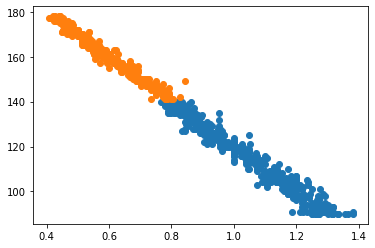

2.780586916275508


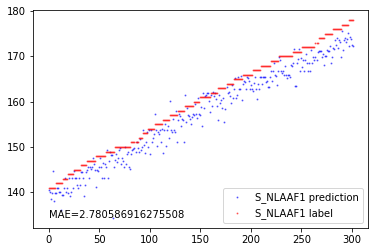

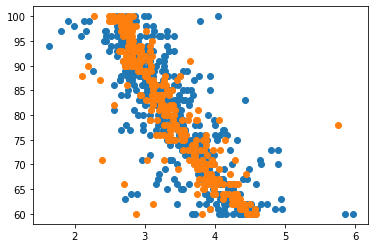

4.501226912773568


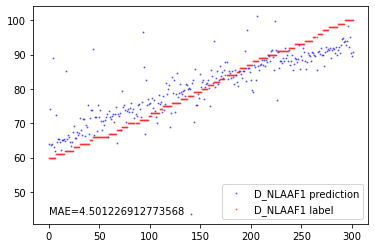

In [18]:
from sklearn.linear_model import LinearRegression as LR

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(NLAAF1_features_train[:, 0],NLAAF1_features_test[:, 0],labels_0_train[idxs_1_train, 4],labels_0_test[idxs_1_test, 4],'S_NLAAF1')
plot_plot(NLAAF1_features_train[:, 1],NLAAF1_features_test[:, 1],labels_0_train[idxs_1_train, 5],labels_0_test[idxs_1_test, 5],'D_NLAAF1')


In [17]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()